In [1]:
# # !pip uninstall -y torch torchvision torchaudio
# # !pip install torch==2.1.0+cu121 torchvision==0.16.0+cu121 torchaudio==2.1.0+cu121 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install albumentations
# !pip install ftfy
# # !pip install causal_conv1d==1.1.1
# # !pip install mamba-ssm==1.2.0.post1
# !pip install transformers==4.51.1
# !pip install accelerate==1.3.0

In [2]:
# from mamba_ssm.ops.selective_scan_interface import selective_scan_fn, selective_scan_ref

import os
import glob
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchmetrics import Accuracy, JaccardIndex
from tqdm import tqdm


# Cấu hình OpenCV để tránh xung đột
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

# Định nghĩa các hằng số
CLASSES = ["Noise", "LTE", "NR", "Radar"]
COLORMAP = [[0, 0, 0], [80, 80, 80], [160, 160, 160], [255, 255, 255]]

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# data

In [ ]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])



# Định nghĩa Dataset
class SearchDataset(Dataset):
    def __init__(self, root="/kaggle/input", image_set="train", download=True, transform=None):
        self.images = sorted(glob.glob(os.path.join(root, image_set, 'input', '*.png')))
        self.masks = sorted(glob.glob(os.path.join(root, image_set, 'label', '*.png')))
        self.transform = transform
        self.classes = len(COLORMAP)  # Số lớp (4 trong trường hợp này)

    def __len__(self):
        return len(self.images)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # Chuyển mask RGB thành nhãn lớp đơn kênh
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width), dtype=np.uint8)  # Chỉ cần 1 kênh cho nhãn lớp
        for label_index, label_color in enumerate(COLORMAP):
            segmentation_mask[np.all(mask == label_color, axis=-1)] = label_index
        return segmentation_mask

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)  # Giờ mask là 2D với nhãn lớp

        if self.transform is not None:
            image = self.transform(image) 
            mask = torch.from_numpy(mask).long()  # Chuyển mask thành tensor long

        return image, mask

# Tạo dataset và dataloader
train_dataset = SearchDataset(image_set="train", download=True, transform=train_transform)
test_dataset = SearchDataset(image_set="val", download=False, transform=train_transform)

# Cấu hình dataloader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 32
n_workers = os.cpu_count()

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers)

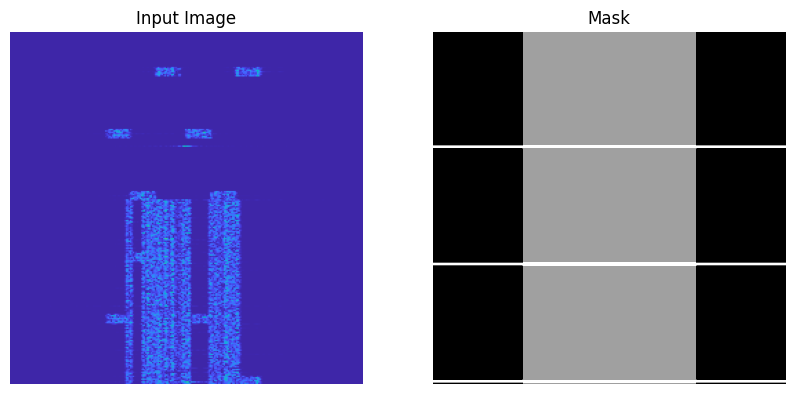

In [4]:
import matplotlib.pyplot as plt

# Lấy ảnh đầu tiên từ tập test
test_dataset = SearchDataset(image_set="val", download=False, transform=None)  # Không áp dụng transform để lấy ảnh gốc
image, mask = test_dataset[0]

# Chuyển đổi tensor hoặc numpy array về định dạng phù hợp để hiển thị
image = image.numpy().transpose(1, 2, 0) if isinstance(image, torch.Tensor) else image  # Nếu ảnh là tensor, chuyển về numpy
mask = mask.numpy() if isinstance(mask, torch.Tensor) else mask  # Chuyển mask về numpy nếu cần

# Tạo colormap cho mask dựa trên COLORMAP
from matplotlib.colors import ListedColormap
cmap = ListedColormap(np.array(COLORMAP) / 255.0)  # Chuẩn hóa COLORMAP về [0, 1]

# Hiển thị ảnh và mask
plt.figure(figsize=(10, 5))

# Hiển thị ảnh gốc
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(image)
plt.axis('off')

# Hiển thị mask
plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(mask, cmap=cmap, vmin=0, vmax=len(COLORMAP)-1)
plt.axis('off')

plt.show()

# model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RecycleConv(nn.Module): # 3x1
    def __init__(self, c1, c2, k=3, s=1, p=None, g=1, d=1, recg=4, use_relu=True):
        super().__init__()
        self.g = recg
        self.c_ = c2 // self.g
        self.use_relu = use_relu

        # Xử lý kernel size là tuple hoặc số nguyên
        self.k = k if isinstance(k, tuple) else (k, k)
        kh, kw = self.k

        # Xử lý stride là tuple hoặc số nguyên
        self.s = s if isinstance(s, tuple) else (s, s)

        # Tính padding nếu không được cung cấp
        self.p = p
        if p is None:
            ph = (kh - 1) // 2
            pw = (kw - 1) // 2
            self.p = (ph, pw)

        # Khởi tạo convolution
        self.conv = nn.Conv2d(c1 // self.g, self.c_, kernel_size=self.k, stride=self.s, 
                            padding=self.p, groups=g, dilation=d, bias=False)
        
        # BatchNorm và ReLU
        if self.use_relu:
            self.bn_silu = nn.Sequential(
                nn.BatchNorm2d(self.c_),
                nn.ReLU(inplace=True)
            )
        else:
            self.bn_silu = nn.BatchNorm2d(self.c_)

        # Tạo scale riêng cho từng group (trừ group 0)
        self.trainable_scale_cc = nn.ParameterList([
            nn.Parameter(torch.ones(c1 // self.g, 1, 1)) for _ in range(1, self.g)
        ])
        self.trainable_scale_sc = nn.ParameterList([
            nn.Parameter(torch.ones(1, kh, kw)) for _ in range(1, self.g)
        ])

        self.saved_kernel = None

    def forward(self, x):
        chunks = torch.chunk(x, self.g, dim=1)
        processed_chunks = []

        for i, c in enumerate(chunks):
            if i == 0:
                out = self.bn_silu(self.conv(c))
            else:
                weight = self.conv.weight.clone()
                weight = weight * self.trainable_scale_cc[i - 1] * self.trainable_scale_sc[i - 1]
                out = F.conv2d(c, weight, padding=self.p, stride=self.s)
                out = self.bn_silu(out)
            processed_chunks.append(out)
        return torch.cat(processed_chunks, dim=1)

class RecycleBasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, groups=1, downsample=None):
        super().__init__()
        self.recg=groups
        self.recconv1 = RecycleConv(c1=in_channels, c2=out_channels, k=(3,3), s=stride, recg=4, use_relu=True)
        self.recconv2 = RecycleConv(c1=out_channels, c2=out_channels, k=(3,3), s=1, recg=4, use_relu=False)
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        out = self.recconv1(x)
        out = self.recconv2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out
# ======== BasicBlock ========
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, groups=1, downsample=None):
        super().__init__()
        self.groups = groups
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False, groups=groups)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False, groups=groups)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out
        
class BasicGroupBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, groups=1, downsample=None):
        super().__init__()
        self.groups = groups
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False, groups=8)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False, groups=8)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out
        
# ======== ResNetEncoder ========
class ResNetEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.gshallow = 1
        self.gdeep = 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, blocks=2, stride=1, groups=self.gshallow)
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2, groups=self.gshallow)
        # self.layer3 = self._make_layer(128, 256, blocks=2, stride=2, groups=self.gdeep)
        # self.layer4 = self._make_layer(256, 512, blocks=2, stride=2, groups=self.gdeep)
        self.layer3 = self._make_rec_layer(128, 256, blocks=2, stride=2, groups=self.gdeep)
        self.layer4 = self._make_rec_layer(256, 512, blocks=2, stride=2, groups=self.gdeep)

    def _make_layer(self, in_channels, out_channels, blocks, stride, groups):
        downsample = None
        if stride != 1 or in_channels != out_channels: #res identity
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = [BasicBlock(in_channels, out_channels, stride, groups, downsample)]
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
        
    def _make_rec_layer(self, in_channels, out_channels, blocks, stride, groups):
        downsample = None
        if stride != 1 or in_channels != out_channels: #res identity
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = [RecycleBasicBlock(in_channels, out_channels, stride, groups, downsample)]
        for _ in range(1, blocks):
            layers.append(RecycleBasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x0 = self.relu(self.bn1(self.conv1(x)))  # [B, 64, H/2, W/2]
        x1 = self.maxpool(x0)                   # [B, 64, H/4, W/4]
        x2 = self.layer1(x1)                    # [B, 64, H/4, W/4]
        x3 = self.layer2(x2)                    # [B, 128, H/8, W/8]
        x4 = self.layer3(x3)                    # [B, 256, H/16, W/16]
        x5 = self.layer4(x4)                    # [B, 512, H/32, W/32]
        return [x0, x2, x3, x4, x5]

# ======== DecoderBlock ========
class Conv2dReLU(nn.Sequential):
    def __init__(self, in_channels, out_channels, groups):
        super().__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False, groups= groups),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

class Attention(nn.Module):
    def __init__(self):
        super().__init__()
        self.attention = nn.Identity()
    def forward(self, x):
        return self.attention(x)
class SpatialAttention(nn.Module):
    """Spatial-attention module."""

    def __init__(self, kernel_size=7):
        """Initialize Spatial-attention module with kernel size argument."""
        super().__init__()
        assert kernel_size in {3, 7}, "kernel size must be 3 or 7"
        padding = 3 if kernel_size == 7 else 1
        self.cv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.act = nn.Sigmoid()

    def forward(self, x):
        """Apply channel and spatial attention on input for feature recalibration."""
        return x * self.act(self.cv1(torch.cat([torch.mean(x, 1, keepdim=True), torch.max(x, 1, keepdim=True)[0]], 1)))
def channel_shuffle(x, groups=2):  ##shuffle channel
    # RESHAPE----->transpose------->Flatten
    B, C, H, W = x.size()
    out = x.view(B, groups, C // groups, H, W).permute(0, 2, 1, 3, 4).contiguous()
    out = out.view(B, C, H, W)
    return out
class GCT(nn.Module):
    def __init__(self, num_channels):
        super(GCT, self).__init__()
        self.epsilon = 1e-5
        self.alpha = nn.Parameter(torch.ones(1, num_channels, 1, 1))
        self.gamma = nn.Parameter(torch.zeros(1, num_channels, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, num_channels, 1, 1))
        self.mode = 'l2'
        self.after_relu = False

    def forward(self, x):
        embedding = (x.pow(2).sum((2, 3), keepdim=True) + self.epsilon).pow(0.5) * self.alpha
        norm = self.gamma / (embedding.pow(2).mean(dim=1, keepdim=True) + self.epsilon).pow(0.5)
        gate = 1. + torch.tanh(embedding * norm + self.beta)
        # print('cool')
        return x * gate
# class SFF(nn.Module):
#     def __init__(self, inc_list):
#         super().__init__()
#         self.in_channels = inc_list
#         self.total_in_channels = sum(inc_list)
#         self.sab = SpatialAttention(7)
#         self.gsc = GCT(num_channels=self.total_in_channels)

#     def forward(self, x_list):
#         # Gộp tất cả các đặc trưng đầu vào theo kênh
#         fused = self.gsc(torch.cat(x_list, dim=1))

#         # Cắt lại từng phần tương ứng với từng đầu vào
#         outputs = []
#         start = 0
#         for idx, c in enumerate(self.in_channels):
#             end = start + c
#             f = fused[:, start:end, :, :]
#             o = f + self.sab(x_list[idx])
#             outputs.append(o)
#             start = end

#         # Nối lại tất cả đầu ra
#         return torch.cat(outputs, dim=1)

class SFF(nn.Module):  #SA1
    def __init__(self, inc_list):
        super().__init__()
        self.in_channels = inc_list
        self.sab = SpatialAttention(7)
        self.total_in_channels = sum(inc_list)
        self.gsc = GCT(num_channels=self.total_in_channels)

    def forward(self, x_list):
        # Áp dụng Spatial Attention cho từng đặc trưng đầu vào
        sa_outputs = [self.sab(x) for x in x_list]

        # Nối tất cả đặc trưng đã qua SA
        fused = torch.cat(sa_outputs, dim=1)
        # Áp dụng GCT cho đặc trưng đã được nối
        out = self.gsc(fused)
        out = channel_shuffle(out,4)
        return out


class UnetSFFDecoderBlock(nn.Module):
    def __init__(self, decoder_channels, skip_channels, skip_down, out_channels, groups):
        super().__init__()
        self.sff = SFF(inc_list=[decoder_channels, skip_channels, skip_down])#, in_channel=decoder_channels, outc=decoder_channels)
        self.conv1 = Conv2dReLU(in_channels=(decoder_channels + skip_channels+skip_down), out_channels=out_channels, groups=1)
        self.attention1 = Attention()
        self.conv2 = Conv2dReLU(out_channels, out_channels, groups=1)
        self.attention2 = Attention()

    def forward(self, x, skip=None, skip_down=None):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if skip is not None:
            x = self.sff([x, skip, skip_down])
        x = self.conv1(x)
        x = self.attention1(x)
        x = self.conv2(x)
        x = self.attention2(x)
        return x

class UnetDecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, groups):
        super().__init__()
        self.conv1 = Conv2dReLU(in_channels, out_channels, groups)
        self.attention1 = Attention()
        self.conv2 = Conv2dReLU(out_channels, out_channels, groups)
        self.attention2 = Attention()

    def forward(self, x, skip=None, skip_down=None):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if skip is not None:
            if skip_down is not None:
                x = torch.cat([x, skip, skip_down], dim=1)
            else:
                x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.attention1(x)
        x = self.conv2(x)
        x = self.attention2(x)
        return x


class UnetGroupDecoderBlock(nn.Module):
    def __init__(self, decoder_channels, skip_channels, skip_down, out_channels, groups):
        super().__init__()
        self.sff = SFF(inc_list=[decoder_channels, skip_channels, skip_down])#, in_channel=decoder_channels, outc=decoder_channels)
        self.conv1 = RecycleConv(c1=(decoder_channels + skip_channels+skip_down), c2=out_channels, k=3, s=1, recg=4, use_relu=False)
        self.attention1 = Attention()
        self.conv2 = RecycleConv(c1=out_channels, c2=out_channels, k=3, s=1, recg=4, use_relu=False)
        self.attention2 = Attention()

    def forward(self, x, skip=None, skip_down=None):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if skip is not None:
            x = self.sff([x,skip , skip_down])
        x = self.conv1(x)
        x = self.attention1(x)
        x = self.conv2(x)
        x = self.attention2(x)
        return x
class Downsampling(nn.Sequential):
    def __init__(self, in_channels, out_channels, k=3, d=1):
        # Xử lý kernel size là tuple hoặc số nguyên
        k = k if isinstance(k, tuple) else (k, k)
        kh, kw = k

        # Tính padding tự động để đầu ra giảm một nửa với dilation
        ph = (d * (kh - 1) + 1) // 2
        pw = (d * (kw - 1) + 1) // 2
        padding = (ph, pw)

        # Khởi tạo các layer trong nn.Sequential
        super().__init__(
            # Depthwise convolution
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=in_channels,  # Depthwise giữ số kênh
                kernel_size=k,
                stride=2,  # Downsampling với stride=2
                padding=padding,
                dilation=d,
                bias=False,
                groups=in_channels  # Depthwise convolution
            ),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            # Pointwise convolution
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,  # Điều chỉnh số kênh
                kernel_size=1,
                stride=1,
                padding=0,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
class UnetDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.center = nn.Identity()
        self.gshallow = 1
        self.gdeep = 1

        # Khởi tạo các block
        self.blocks = nn.ModuleList([
            UnetGroupDecoderBlock(512 ,256 , 128, 256, self.gdeep),
            UnetSFFDecoderBlock(256 , 128 , 64, 128, self.gshallow),
            UnetSFFDecoderBlock(128 , 64 , 64, 64, self.gshallow),
            UnetDecoderBlock(64 + 64, 32, self.gshallow),
            UnetDecoderBlock(32, 16, self.gshallow),
        ])

        # Khởi tạo các layer Downsampling cho skip connections
        self.downsamplers = nn.ModuleList([
            Downsampling(in_channels=128, out_channels=128, k=15, d=2),  # Cho x3
            Downsampling(in_channels=64, out_channels=64, k=9, d=2),    # Cho x2
            Downsampling(in_channels=64, out_channels=64, k=3, d=2),    # Cho x1
            # nn.Identity(),  # Tương ứng với None
            # nn.Identity(),  # Tương ứng với None

        ])

    def forward(self, features):
        x5, x4, x3, x2, x1 = features[::-1]  # reversed for decoder
        x = self.center(x5)
        skips = [x4, x3, x2, x1, None]
        # Áp dụng Downsampling lên x3, x2, x1
        skip_downs = [
            self.downsamplers[0](x3),  # k=15, d=2
            self.downsamplers[1](x2),  # k=9, d=2
            self.downsamplers[2](x1),  # k=3, d=2
            None,
            None
        ]

        for block, skip, skip_down in zip(self.blocks, skips, skip_downs):
            x = block(x, skip, skip_down)
        return x
# # ======== UnetDecoder ========
# class UnetDecoder(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.center = nn.Identity()
#         self.gshallow = 1
#         self.gdeep = 1
#         self.blocks = nn.ModuleList([
#             UnetGroupDecoderBlock(512 + 256 + 128, 256, self.gdeep), #cộng thêm channel
#             UnetDecoderBlock(256 + 128 + 64, 128, self.gshallow),
#             UnetDecoderBlock(128 + 64 + 64, 64, self.gshallow),
#             UnetDecoderBlock(64 + 64, 32, self.gshallow),
#             UnetDecoderBlock(32, 16, self.gshallow),
#         ])
#         self.down = Downsampling()

#     def forward(self, features):
#         x5, x4, x3, x2, x1 = features[::-1]  # reversed for decoder
#         x = self.center(x5)
#         skips = [x4, x3, x2, x1, None]
#         skip_down = [self.down(x3, k=15, d=2), self.down(x2, k=9, d=2), self.down(x1, k=3, d=2), None, None]
#         for block, skip in zip(self.blocks, skips):
#             x = block(x, skip, skip_down)
#         return x

# ======== SegmentationHead ========
class SegmentationHead(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.Identity(),
            nn.Identity()  # Placeholder for activation
        )

# ======== Full U-Net ========
class Unet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.encoder = ResNetEncoder()
        self.decoder = UnetDecoder()
        self.segmentation_head = SegmentationHead(16, num_classes)

    def forward(self, x):
        features = self.encoder(x)
        x = self.decoder(features)
        x = self.segmentation_head(x)
        return x
model = Unet(4).to(device)
model = nn.DataParallel(model)

# print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Tổng số tham số có thể huấn luyện: {total_params:,}")
print(model)
"""
--Unet_recon4_dealleg_sand
"""

Tổng số tham số có thể huấn luyện: 2,632,056
DataParallel(
  (module): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

'\n--Unet_recon4_dealleg_sand\n'

# train

Không có checkpoint được cung cấp. Bắt đầu training từ đầu.


Evaluating: 100%|██████████| 273/273 [01:03<00:00,  4.27it/s]



--- Epoch 1/60 ---
Current LR: 0.001000
Train: Loss=0.2724, GlobalAcc=0.9056, MeanIoU=0.6751
Test:  Loss=0.1684, GlobalAcc=0.9334, MeanIoU=0.7831
Đã lưu checkpoint của epoch 1 tại: epoch_1_GlobalAccuracy_0.9334_MeanIoU_0.7831.pth
--> Đạt Best Mean IoU mới: 0.7831 tại epoch 1
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:55<00:00,  4.95it/s]



--- Epoch 2/60 ---
Current LR: 0.001000
Train: Loss=0.1126, GlobalAcc=0.9554, MeanIoU=0.8497
Test:  Loss=0.1070, GlobalAcc=0.9576, MeanIoU=0.8560
Đã lưu checkpoint của epoch 2 tại: epoch_2_GlobalAccuracy_0.9576_MeanIoU_0.8560.pth
--> Đạt Best Mean IoU mới: 0.8560 tại epoch 2
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:54<00:00,  4.97it/s]



--- Epoch 3/60 ---
Current LR: 0.001000
Train: Loss=0.0878, GlobalAcc=0.9651, MeanIoU=0.8741
Test:  Loss=0.1081, GlobalAcc=0.9550, MeanIoU=0.8512
Đã lưu checkpoint của epoch 3 tại: epoch_3_GlobalAccuracy_0.9550_MeanIoU_0.8512.pth
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:58<00:00,  4.68it/s]



--- Epoch 4/60 ---
Current LR: 0.001000
Train: Loss=0.0727, GlobalAcc=0.9714, MeanIoU=0.8892
Test:  Loss=0.0790, GlobalAcc=0.9699, MeanIoU=0.8867
Đã lưu checkpoint của epoch 4 tại: epoch_4_GlobalAccuracy_0.9699_MeanIoU_0.8867.pth
--> Đạt Best Mean IoU mới: 0.8867 tại epoch 4
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:55<00:00,  4.88it/s]



--- Epoch 5/60 ---
Current LR: 0.001000
Train: Loss=0.0628, GlobalAcc=0.9753, MeanIoU=0.9018
Test:  Loss=0.0841, GlobalAcc=0.9693, MeanIoU=0.8916
Đã lưu checkpoint của epoch 5 tại: epoch_5_GlobalAccuracy_0.9693_MeanIoU_0.8916.pth
--> Đạt Best Mean IoU mới: 0.8916 tại epoch 5
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:59<00:00,  4.58it/s]



--- Epoch 6/60 ---
Current LR: 0.001000
Train: Loss=0.0549, GlobalAcc=0.9785, MeanIoU=0.9152
Test:  Loss=0.0748, GlobalAcc=0.9715, MeanIoU=0.9019
Đã lưu checkpoint của epoch 6 tại: epoch_6_GlobalAccuracy_0.9715_MeanIoU_0.9019.pth
--> Đạt Best Mean IoU mới: 0.9019 tại epoch 6
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:56<00:00,  4.83it/s]



--- Epoch 7/60 ---
Current LR: 0.001000
Train: Loss=0.0505, GlobalAcc=0.9805, MeanIoU=0.9243
Test:  Loss=0.0634, GlobalAcc=0.9763, MeanIoU=0.9108
Đã lưu checkpoint của epoch 7 tại: epoch_7_GlobalAccuracy_0.9763_MeanIoU_0.9108.pth
--> Đạt Best Mean IoU mới: 0.9108 tại epoch 7
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [01:11<00:00,  3.81it/s]



--- Epoch 8/60 ---
Current LR: 0.001000
Train: Loss=0.0414, GlobalAcc=0.9841, MeanIoU=0.9376
Test:  Loss=0.0637, GlobalAcc=0.9774, MeanIoU=0.9255
Đã lưu checkpoint của epoch 8 tại: epoch_8_GlobalAccuracy_0.9774_MeanIoU_0.9255.pth
--> Đạt Best Mean IoU mới: 0.9255 tại epoch 8
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:57<00:00,  4.73it/s]



--- Epoch 9/60 ---
Current LR: 0.001000
Train: Loss=0.0372, GlobalAcc=0.9857, MeanIoU=0.9430
Test:  Loss=0.0666, GlobalAcc=0.9797, MeanIoU=0.9322
Đã lưu checkpoint của epoch 9 tại: epoch_9_GlobalAccuracy_0.9797_MeanIoU_0.9322.pth
--> Đạt Best Mean IoU mới: 0.9322 tại epoch 9
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:57<00:00,  4.78it/s]



--- Epoch 10/60 ---
Current LR: 0.001000
Train: Loss=0.0356, GlobalAcc=0.9864, MeanIoU=0.9457
Test:  Loss=0.0655, GlobalAcc=0.9764, MeanIoU=0.9068
Đã lưu checkpoint của epoch 10 tại: epoch_10_GlobalAccuracy_0.9764_MeanIoU_0.9068.pth
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:57<00:00,  4.73it/s]



--- Epoch 11/60 ---
Current LR: 0.001000
Train: Loss=0.0310, GlobalAcc=0.9881, MeanIoU=0.9504
Test:  Loss=0.0679, GlobalAcc=0.9780, MeanIoU=0.9311
Đã lưu checkpoint của epoch 11 tại: epoch_11_GlobalAccuracy_0.9780_MeanIoU_0.9311.pth
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:57<00:00,  4.77it/s]



--- Epoch 12/60 ---
Current LR: 0.001000
Train: Loss=0.0293, GlobalAcc=0.9889, MeanIoU=0.9525
Test:  Loss=0.0848, GlobalAcc=0.9751, MeanIoU=0.9238
Đã lưu checkpoint của epoch 12 tại: epoch_12_GlobalAccuracy_0.9751_MeanIoU_0.9238.pth
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:57<00:00,  4.72it/s]



--- Epoch 13/60 ---
Current LR: 0.001000
Train: Loss=0.0276, GlobalAcc=0.9896, MeanIoU=0.9548
Test:  Loss=0.0560, GlobalAcc=0.9806, MeanIoU=0.9337
Đã lưu checkpoint của epoch 13 tại: epoch_13_GlobalAccuracy_0.9806_MeanIoU_0.9337.pth
--> Đạt Best Mean IoU mới: 0.9337 tại epoch 13
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:57<00:00,  4.73it/s]



--- Epoch 14/60 ---
Current LR: 0.001000
Train: Loss=0.0253, GlobalAcc=0.9905, MeanIoU=0.9571
Test:  Loss=0.0592, GlobalAcc=0.9782, MeanIoU=0.9338
Đã lưu checkpoint của epoch 14 tại: epoch_14_GlobalAccuracy_0.9782_MeanIoU_0.9338.pth
--> Đạt Best Mean IoU mới: 0.9338 tại epoch 14
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:58<00:00,  4.64it/s]



--- Epoch 15/60 ---
Current LR: 0.001000
Train: Loss=0.0219, GlobalAcc=0.9918, MeanIoU=0.9601
Test:  Loss=0.0614, GlobalAcc=0.9817, MeanIoU=0.9396
Đã lưu checkpoint của epoch 15 tại: epoch_15_GlobalAccuracy_0.9817_MeanIoU_0.9396.pth
--> Đạt Best Mean IoU mới: 0.9396 tại epoch 15
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:58<00:00,  4.70it/s]



--- Epoch 16/60 ---
Current LR: 0.001000
Train: Loss=0.0235, GlobalAcc=0.9912, MeanIoU=0.9593
Test:  Loss=0.0643, GlobalAcc=0.9829, MeanIoU=0.9431
Đã lưu checkpoint của epoch 16 tại: epoch_16_GlobalAccuracy_0.9829_MeanIoU_0.9431.pth
--> Đạt Best Mean IoU mới: 0.9431 tại epoch 16
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:58<00:00,  4.63it/s]



--- Epoch 17/60 ---
Current LR: 0.001000
Train: Loss=0.0185, GlobalAcc=0.9931, MeanIoU=0.9635
Test:  Loss=0.0845, GlobalAcc=0.9815, MeanIoU=0.9349
Đã lưu checkpoint của epoch 17 tại: epoch_17_GlobalAccuracy_0.9815_MeanIoU_0.9349.pth
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:57<00:00,  4.75it/s]



--- Epoch 18/60 ---
Current LR: 0.001000
Train: Loss=0.0217, GlobalAcc=0.9919, MeanIoU=0.9613
Test:  Loss=0.0644, GlobalAcc=0.9807, MeanIoU=0.9333
Đã lưu checkpoint của epoch 18 tại: epoch_18_GlobalAccuracy_0.9807_MeanIoU_0.9333.pth
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:57<00:00,  4.73it/s]



--- Epoch 19/60 ---
Current LR: 0.001000
Train: Loss=0.0143, GlobalAcc=0.9946, MeanIoU=0.9672
Test:  Loss=0.0612, GlobalAcc=0.9851, MeanIoU=0.9492
Đã lưu checkpoint của epoch 19 tại: epoch_19_GlobalAccuracy_0.9851_MeanIoU_0.9492.pth
--> Đạt Best Mean IoU mới: 0.9492 tại epoch 19
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:56<00:00,  4.81it/s]



--- Epoch 20/60 ---
Current LR: 0.001000
Train: Loss=0.0131, GlobalAcc=0.9951, MeanIoU=0.9684
Test:  Loss=0.0653, GlobalAcc=0.9842, MeanIoU=0.9447
Đã lưu checkpoint của epoch 20 tại: epoch_20_GlobalAccuracy_0.9842_MeanIoU_0.9447.pth
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:56<00:00,  4.79it/s]



--- Epoch 21/60 ---
Current LR: 0.000200
Train: Loss=0.0090, GlobalAcc=0.9966, MeanIoU=0.9729
Test:  Loss=0.0566, GlobalAcc=0.9866, MeanIoU=0.9530
Đã lưu checkpoint của epoch 21 tại: epoch_21_GlobalAccuracy_0.9866_MeanIoU_0.9530.pth
--> Đạt Best Mean IoU mới: 0.9530 tại epoch 21
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:57<00:00,  4.75it/s]



--- Epoch 22/60 ---
Current LR: 0.000200
Train: Loss=0.0075, GlobalAcc=0.9972, MeanIoU=0.9744
Test:  Loss=0.0609, GlobalAcc=0.9867, MeanIoU=0.9530
Đã lưu checkpoint của epoch 22 tại: epoch_22_GlobalAccuracy_0.9867_MeanIoU_0.9530.pth
--> Đạt Best Mean IoU mới: 0.9530 tại epoch 22
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:57<00:00,  4.71it/s]



--- Epoch 23/60 ---
Current LR: 0.000200
Train: Loss=0.0069, GlobalAcc=0.9974, MeanIoU=0.9751
Test:  Loss=0.0678, GlobalAcc=0.9866, MeanIoU=0.9531
Đã lưu checkpoint của epoch 23 tại: epoch_23_GlobalAccuracy_0.9866_MeanIoU_0.9531.pth
--> Đạt Best Mean IoU mới: 0.9531 tại epoch 23
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:57<00:00,  4.73it/s]



--- Epoch 24/60 ---
Current LR: 0.000200
Train: Loss=0.0065, GlobalAcc=0.9975, MeanIoU=0.9757
Test:  Loss=0.0701, GlobalAcc=0.9867, MeanIoU=0.9532
Đã lưu checkpoint của epoch 24 tại: epoch_24_GlobalAccuracy_0.9867_MeanIoU_0.9532.pth
--> Đạt Best Mean IoU mới: 0.9532 tại epoch 24
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:57<00:00,  4.73it/s]



--- Epoch 25/60 ---
Current LR: 0.000200
Train: Loss=0.0061, GlobalAcc=0.9977, MeanIoU=0.9765
Test:  Loss=0.0722, GlobalAcc=0.9866, MeanIoU=0.9530
Đã lưu checkpoint của epoch 25 tại: epoch_25_GlobalAccuracy_0.9866_MeanIoU_0.9530.pth
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [01:22<00:00,  3.30it/s]



--- Epoch 26/60 ---
Current LR: 0.000200
Train: Loss=0.0058, GlobalAcc=0.9978, MeanIoU=0.9771
Test:  Loss=0.0760, GlobalAcc=0.9866, MeanIoU=0.9537
Đã lưu checkpoint của epoch 26 tại: epoch_26_GlobalAccuracy_0.9866_MeanIoU_0.9537.pth
--> Đạt Best Mean IoU mới: 0.9537 tại epoch 26
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:57<00:00,  4.78it/s]



--- Epoch 27/60 ---
Current LR: 0.000200
Train: Loss=0.0055, GlobalAcc=0.9979, MeanIoU=0.9777
Test:  Loss=0.0736, GlobalAcc=0.9866, MeanIoU=0.9531
Đã lưu checkpoint của epoch 27 tại: epoch_27_GlobalAccuracy_0.9866_MeanIoU_0.9531.pth
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:58<00:00,  4.66it/s]



--- Epoch 28/60 ---
Current LR: 0.000200
Train: Loss=0.0053, GlobalAcc=0.9980, MeanIoU=0.9783
Test:  Loss=0.0719, GlobalAcc=0.9867, MeanIoU=0.9541
Đã lưu checkpoint của epoch 28 tại: epoch_28_GlobalAccuracy_0.9867_MeanIoU_0.9541.pth
--> Đạt Best Mean IoU mới: 0.9541 tại epoch 28
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:59<00:00,  4.58it/s]



--- Epoch 29/60 ---
Current LR: 0.000200
Train: Loss=0.0052, GlobalAcc=0.9980, MeanIoU=0.9787
Test:  Loss=0.0763, GlobalAcc=0.9867, MeanIoU=0.9541
Đã lưu checkpoint của epoch 29 tại: epoch_29_GlobalAccuracy_0.9867_MeanIoU_0.9541.pth
--> Đạt Best Mean IoU mới: 0.9541 tại epoch 29
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:58<00:00,  4.66it/s]



--- Epoch 30/60 ---
Current LR: 0.000200
Train: Loss=0.0049, GlobalAcc=0.9981, MeanIoU=0.9794
Test:  Loss=0.0840, GlobalAcc=0.9865, MeanIoU=0.9531
Đã lưu checkpoint của epoch 30 tại: epoch_30_GlobalAccuracy_0.9865_MeanIoU_0.9531.pth
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:57<00:00,  4.76it/s]



--- Epoch 31/60 ---
Current LR: 0.000200
Train: Loss=0.0046, GlobalAcc=0.9983, MeanIoU=0.9801
Test:  Loss=0.0855, GlobalAcc=0.9866, MeanIoU=0.9532
Đã lưu checkpoint của epoch 31 tại: epoch_31_GlobalAccuracy_0.9866_MeanIoU_0.9532.pth
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:58<00:00,  4.68it/s]



--- Epoch 32/60 ---
Current LR: 0.000200
Train: Loss=0.0044, GlobalAcc=0.9984, MeanIoU=0.9806
Test:  Loss=0.0873, GlobalAcc=0.9865, MeanIoU=0.9540
Đã lưu checkpoint của epoch 32 tại: epoch_32_GlobalAccuracy_0.9865_MeanIoU_0.9540.pth
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:57<00:00,  4.73it/s]



--- Epoch 33/60 ---
Current LR: 0.000200
Train: Loss=0.0043, GlobalAcc=0.9984, MeanIoU=0.9810
Test:  Loss=0.0816, GlobalAcc=0.9865, MeanIoU=0.9546
Đã lưu checkpoint của epoch 33 tại: epoch_33_GlobalAccuracy_0.9865_MeanIoU_0.9546.pth
--> Đạt Best Mean IoU mới: 0.9546 tại epoch 33
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:58<00:00,  4.64it/s]



--- Epoch 34/60 ---
Current LR: 0.000200
Train: Loss=0.0043, GlobalAcc=0.9984, MeanIoU=0.9816
Test:  Loss=0.0883, GlobalAcc=0.9865, MeanIoU=0.9546
Đã lưu checkpoint của epoch 34 tại: epoch_34_GlobalAccuracy_0.9865_MeanIoU_0.9546.pth
--> Đạt Best Mean IoU mới: 0.9546 tại epoch 34
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:57<00:00,  4.76it/s]



--- Epoch 35/60 ---
Current LR: 0.000200
Train: Loss=0.0039, GlobalAcc=0.9985, MeanIoU=0.9823
Test:  Loss=0.0916, GlobalAcc=0.9864, MeanIoU=0.9547
Đã lưu checkpoint của epoch 35 tại: epoch_35_GlobalAccuracy_0.9864_MeanIoU_0.9547.pth
--> Đạt Best Mean IoU mới: 0.9547 tại epoch 35
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:57<00:00,  4.74it/s]



--- Epoch 36/60 ---
Current LR: 0.000200
Train: Loss=0.0037, GlobalAcc=0.9986, MeanIoU=0.9828
Test:  Loss=0.0828, GlobalAcc=0.9868, MeanIoU=0.9559
Đã lưu checkpoint của epoch 36 tại: epoch_36_GlobalAccuracy_0.9868_MeanIoU_0.9559.pth
--> Đạt Best Mean IoU mới: 0.9559 tại epoch 36
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:59<00:00,  4.59it/s]



--- Epoch 37/60 ---
Current LR: 0.000200
Train: Loss=0.0039, GlobalAcc=0.9985, MeanIoU=0.9832
Test:  Loss=0.0840, GlobalAcc=0.9867, MeanIoU=0.9541
Đã lưu checkpoint của epoch 37 tại: epoch_37_GlobalAccuracy_0.9867_MeanIoU_0.9541.pth
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:59<00:00,  4.59it/s]



--- Epoch 38/60 ---
Current LR: 0.000200
Train: Loss=0.0036, GlobalAcc=0.9987, MeanIoU=0.9841
Test:  Loss=0.0870, GlobalAcc=0.9870, MeanIoU=0.9560
Đã lưu checkpoint của epoch 38 tại: epoch_38_GlobalAccuracy_0.9870_MeanIoU_0.9560.pth
--> Đạt Best Mean IoU mới: 0.9560 tại epoch 38
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:57<00:00,  4.76it/s]



--- Epoch 39/60 ---
Current LR: 0.000200
Train: Loss=0.0033, GlobalAcc=0.9988, MeanIoU=0.9846
Test:  Loss=0.0951, GlobalAcc=0.9867, MeanIoU=0.9542
Đã lưu checkpoint của epoch 39 tại: epoch_39_GlobalAccuracy_0.9867_MeanIoU_0.9542.pth
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:58<00:00,  4.68it/s]



--- Epoch 40/60 ---
Current LR: 0.000200
Train: Loss=0.0032, GlobalAcc=0.9988, MeanIoU=0.9851
Test:  Loss=0.0935, GlobalAcc=0.9865, MeanIoU=0.9553
Đã lưu checkpoint của epoch 40 tại: epoch_40_GlobalAccuracy_0.9865_MeanIoU_0.9553.pth
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:56<00:00,  4.82it/s]



--- Epoch 41/60 ---
Current LR: 0.000040
Train: Loss=0.0027, GlobalAcc=0.9990, MeanIoU=0.9871
Test:  Loss=0.0938, GlobalAcc=0.9870, MeanIoU=0.9566
Đã lưu checkpoint của epoch 41 tại: epoch_41_GlobalAccuracy_0.9870_MeanIoU_0.9566.pth
--> Đạt Best Mean IoU mới: 0.9566 tại epoch 41
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:57<00:00,  4.75it/s]



--- Epoch 42/60 ---
Current LR: 0.000040
Train: Loss=0.0026, GlobalAcc=0.9990, MeanIoU=0.9876
Test:  Loss=0.1001, GlobalAcc=0.9869, MeanIoU=0.9562
Đã lưu checkpoint của epoch 42 tại: epoch_42_GlobalAccuracy_0.9869_MeanIoU_0.9562.pth
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:59<00:00,  4.55it/s]



--- Epoch 43/60 ---
Current LR: 0.000040
Train: Loss=0.0025, GlobalAcc=0.9991, MeanIoU=0.9879
Test:  Loss=0.1020, GlobalAcc=0.9870, MeanIoU=0.9570
Đã lưu checkpoint của epoch 43 tại: epoch_43_GlobalAccuracy_0.9870_MeanIoU_0.9570.pth
--> Đạt Best Mean IoU mới: 0.9570 tại epoch 43
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:59<00:00,  4.62it/s]



--- Epoch 44/60 ---
Current LR: 0.000040
Train: Loss=0.0024, GlobalAcc=0.9991, MeanIoU=0.9881
Test:  Loss=0.1053, GlobalAcc=0.9870, MeanIoU=0.9568
Đã lưu checkpoint của epoch 44 tại: epoch_44_GlobalAccuracy_0.9870_MeanIoU_0.9568.pth
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:59<00:00,  4.59it/s]



--- Epoch 45/60 ---
Current LR: 0.000040
Train: Loss=0.0023, GlobalAcc=0.9991, MeanIoU=0.9884
Test:  Loss=0.1078, GlobalAcc=0.9871, MeanIoU=0.9564
Đã lưu checkpoint của epoch 45 tại: epoch_45_GlobalAccuracy_0.9871_MeanIoU_0.9564.pth
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [01:00<00:00,  4.51it/s]



--- Epoch 46/60 ---
Current LR: 0.000040
Train: Loss=0.0023, GlobalAcc=0.9991, MeanIoU=0.9887
Test:  Loss=0.1101, GlobalAcc=0.9869, MeanIoU=0.9566
Đã lưu checkpoint của epoch 46 tại: epoch_46_GlobalAccuracy_0.9869_MeanIoU_0.9566.pth
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:59<00:00,  4.59it/s]



--- Epoch 47/60 ---
Current LR: 0.000040
Train: Loss=0.0022, GlobalAcc=0.9992, MeanIoU=0.9889
Test:  Loss=0.1159, GlobalAcc=0.9869, MeanIoU=0.9573
Đã lưu checkpoint của epoch 47 tại: epoch_47_GlobalAccuracy_0.9869_MeanIoU_0.9573.pth
--> Đạt Best Mean IoU mới: 0.9573 tại epoch 47
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:59<00:00,  4.58it/s]



--- Epoch 48/60 ---
Current LR: 0.000040
Train: Loss=0.0022, GlobalAcc=0.9992, MeanIoU=0.9892
Test:  Loss=0.1149, GlobalAcc=0.9871, MeanIoU=0.9567
Đã lưu checkpoint của epoch 48 tại: epoch_48_GlobalAccuracy_0.9871_MeanIoU_0.9567.pth
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [01:00<00:00,  4.53it/s]



--- Epoch 49/60 ---
Current LR: 0.000040
Train: Loss=0.0021, GlobalAcc=0.9992, MeanIoU=0.9895
Test:  Loss=0.1133, GlobalAcc=0.9870, MeanIoU=0.9571
Đã lưu checkpoint của epoch 49 tại: epoch_49_GlobalAccuracy_0.9870_MeanIoU_0.9571.pth
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [01:00<00:00,  4.55it/s]



--- Epoch 50/60 ---
Current LR: 0.000040
Train: Loss=0.0021, GlobalAcc=0.9992, MeanIoU=0.9897
Test:  Loss=0.1143, GlobalAcc=0.9869, MeanIoU=0.9565
Đã lưu checkpoint của epoch 50 tại: epoch_50_GlobalAccuracy_0.9869_MeanIoU_0.9565.pth
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:59<00:00,  4.57it/s]



--- Epoch 51/60 ---
Current LR: 0.000040
Train: Loss=0.0020, GlobalAcc=0.9992, MeanIoU=0.9900
Test:  Loss=0.1194, GlobalAcc=0.9870, MeanIoU=0.9571
Đã lưu checkpoint của epoch 51 tại: epoch_51_GlobalAccuracy_0.9870_MeanIoU_0.9571.pth
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:58<00:00,  4.66it/s]



--- Epoch 52/60 ---
Current LR: 0.000040
Train: Loss=0.0020, GlobalAcc=0.9993, MeanIoU=0.9903
Test:  Loss=0.1183, GlobalAcc=0.9869, MeanIoU=0.9568
Đã lưu checkpoint của epoch 52 tại: epoch_52_GlobalAccuracy_0.9869_MeanIoU_0.9568.pth
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:57<00:00,  4.73it/s]



--- Epoch 53/60 ---
Current LR: 0.000040
Train: Loss=0.0019, GlobalAcc=0.9993, MeanIoU=0.9905
Test:  Loss=0.1175, GlobalAcc=0.9870, MeanIoU=0.9573
Đã lưu checkpoint của epoch 53 tại: epoch_53_GlobalAccuracy_0.9870_MeanIoU_0.9573.pth
--> Đạt Best Mean IoU mới: 0.9573 tại epoch 53
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:57<00:00,  4.76it/s]



--- Epoch 54/60 ---
Current LR: 0.000040
Train: Loss=0.0019, GlobalAcc=0.9993, MeanIoU=0.9908
Test:  Loss=0.1210, GlobalAcc=0.9870, MeanIoU=0.9573
Đã lưu checkpoint của epoch 54 tại: epoch_54_GlobalAccuracy_0.9870_MeanIoU_0.9573.pth
--> Đạt Best Mean IoU mới: 0.9573 tại epoch 54
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:59<00:00,  4.57it/s]



--- Epoch 55/60 ---
Current LR: 0.000040
Train: Loss=0.0018, GlobalAcc=0.9993, MeanIoU=0.9910
Test:  Loss=0.1266, GlobalAcc=0.9869, MeanIoU=0.9569
Đã lưu checkpoint của epoch 55 tại: epoch_55_GlobalAccuracy_0.9869_MeanIoU_0.9569.pth
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:55<00:00,  4.88it/s]



--- Epoch 56/60 ---
Current LR: 0.000040
Train: Loss=0.0018, GlobalAcc=0.9993, MeanIoU=0.9912
Test:  Loss=0.1182, GlobalAcc=0.9870, MeanIoU=0.9571
Đã lưu checkpoint của epoch 56 tại: epoch_56_GlobalAccuracy_0.9870_MeanIoU_0.9571.pth
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:56<00:00,  4.80it/s]



--- Epoch 57/60 ---
Current LR: 0.000040
Train: Loss=0.0017, GlobalAcc=0.9994, MeanIoU=0.9914
Test:  Loss=0.1202, GlobalAcc=0.9870, MeanIoU=0.9575
Đã lưu checkpoint của epoch 57 tại: epoch_57_GlobalAccuracy_0.9870_MeanIoU_0.9575.pth
--> Đạt Best Mean IoU mới: 0.9575 tại epoch 57
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:56<00:00,  4.82it/s]



--- Epoch 58/60 ---
Current LR: 0.000040
Train: Loss=0.0017, GlobalAcc=0.9994, MeanIoU=0.9917
Test:  Loss=0.1263, GlobalAcc=0.9869, MeanIoU=0.9571
Đã lưu checkpoint của epoch 58 tại: epoch_58_GlobalAccuracy_0.9869_MeanIoU_0.9571.pth
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:55<00:00,  4.88it/s]



--- Epoch 59/60 ---
Current LR: 0.000040
Train: Loss=0.0017, GlobalAcc=0.9994, MeanIoU=0.9918
Test:  Loss=0.1265, GlobalAcc=0.9870, MeanIoU=0.9572
Đã lưu checkpoint của epoch 59 tại: epoch_59_GlobalAccuracy_0.9870_MeanIoU_0.9572.pth
--------------------------------------------------


Evaluating: 100%|██████████| 273/273 [00:57<00:00,  4.71it/s]



--- Epoch 60/60 ---
Current LR: 0.000040
Train: Loss=0.0016, GlobalAcc=0.9994, MeanIoU=0.9920
Test:  Loss=0.1264, GlobalAcc=0.9869, MeanIoU=0.9571
Đã lưu checkpoint của epoch 60 tại: epoch_60_GlobalAccuracy_0.9869_MeanIoU_0.9571.pth
--------------------------------------------------

Hoàn tất training sau 60 epochs.
Model tốt nhất đạt Test Mean IoU: 0.9575 tại epoch 57


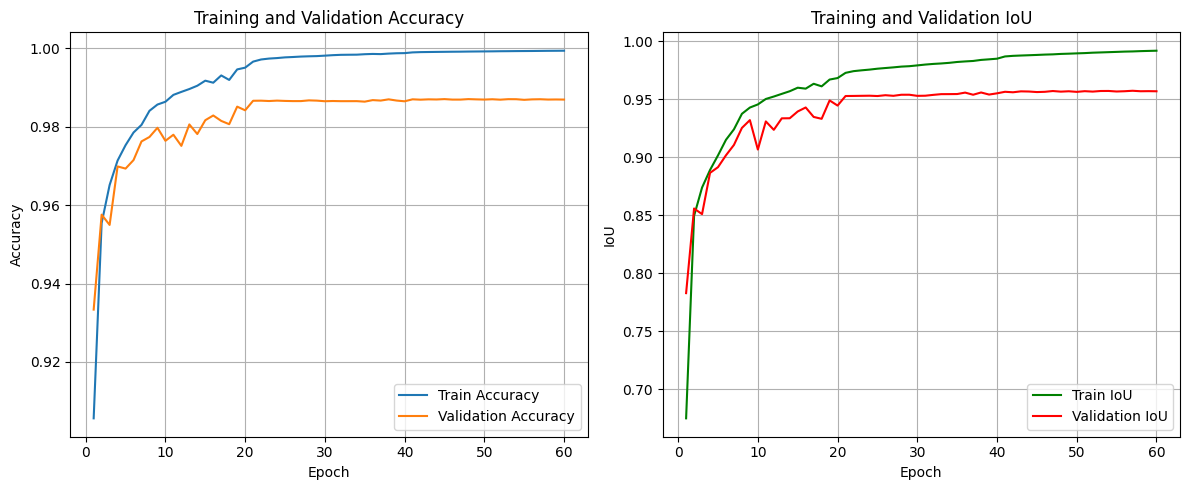

In [6]:
Resume_Train = None

n_eps = 60 # Tổng số epoch muốn train
lr = 1e-3 # Sẽ được dùng bởi optimizer
scheduler_step_size = 20 # Sẽ được dùng bởi scheduler
scheduler_gamma = 0.2 # Sẽ được dùng bởi scheduler
num_classes = 4 # Số lượng lớp của bài toán

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # Giả sử đã định nghĩa ở ngoài
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma) # Giả sử đã định nghĩa

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class AverageMeter: # Giữ nguyên AverageMeter cho loss
    def __init__(self): self.reset()
    def reset(self): self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
    def update(self, val, n=1): self.val = val; self.sum += val * n; self.count += n; self.avg = self.sum / self.count

def evaluate(model, dataloader, criterion, device, current_num_classes): # Đổi tên num_classes để tránh nhầm lẫn
    model.eval()
    test_loss_meter = AverageMeter() # Giữ cho loss
    eval_accuracy_metric = Accuracy(task="multiclass", num_classes=num_classes, average='micro').to(device)
    # eval_accuracy_metric = MulticlassAccuracy(num_classes=current_num_classes).to(device)
    eval_iou_metric = JaccardIndex(task="multiclass", num_classes=num_classes, average='macro').to(device)
    # eval_iou_metric = MulticlassJaccardIndex(num_classes=current_num_classes).to(device)


    with torch.no_grad():
        for x, y in tqdm(dataloader, desc="Evaluating"):
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss_meter.update(loss.item(), n=y.size(0))

            preds = torch.argmax(y_hat, dim=1)

            eval_accuracy_metric.update(preds, y)
            eval_iou_metric.update(preds, y)

    # Tính toán giá trị cuối cùng từ các đối tượng torchmetrics
    final_test_loss = test_loss_meter.avg
    final_test_global_acc = eval_accuracy_metric.compute().item()
    final_test_mean_iou = eval_iou_metric.compute().item()

    return final_test_loss, final_test_global_acc, final_test_mean_iou


# --- Thêm các danh sách để lưu lịch sử metrics ---
train_acc_history = []
train_iou_history = []
test_acc_history = []
test_iou_history = []
# ----------------------------------------------

start_epoch = 1
best_test_mean_iou = 0.0
best_epoch_val = 0

# Phần resume training giữ nguyên
if Resume_Train and os.path.isfile(Resume_Train):
    print(f"Đang tải checkpoint từ: {Resume_Train}")
    checkpoint = torch.load(Resume_Train, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    if 'best_test_mean_iou' in checkpoint:
        best_test_mean_iou = checkpoint['best_test_mean_iou']
        best_epoch_val = checkpoint['best_epoch']
        print(f"Đã tải thông tin best Mean IoU: {best_test_mean_iou:.4f} tại epoch {best_epoch_val}")
    if 'current_test_mean_iou' in checkpoint:
        print(f"Checkpoint được tải là từ epoch {checkpoint['epoch']} với test Mean IoU là {checkpoint.get('current_test_mean_iou', 'N/A'):.4f}")
    elif 'current_test_global_accuracy' in checkpoint:
        print(f"Checkpoint được tải là từ epoch {checkpoint['epoch']} với test accuracy là {checkpoint.get('current_test_global_accuracy', 'N/A')}")
    else:
        print("Checkpoint không chứa thông tin test metrics hiện tại.")
    print(f"Đã tải xong. Tiếp tục training từ epoch {start_epoch}")
else:
    if Resume_Train:
        print(f"Không tìm thấy file checkpoint tại: {Resume_Train}. Bắt đầu training từ đầu.")
    else:
        print("Không có checkpoint được cung cấp. Bắt đầu training từ đầu.")


for ep in range(start_epoch, n_eps + 1):
    model.train()
    train_loss_meter = AverageMeter() # Giữ cho loss

    epoch_global_accuracy_metric = Accuracy(task="multiclass", num_classes=num_classes, average='micro').to(device)
    # epoch_global_accuracy_metric = MulticlassAccuracy(num_classes=num_classes).to(device)
    epoch_mean_iou_metric = JaccardIndex(task="multiclass", num_classes=num_classes, average='macro').to(device)
    # epoch_mean_iou_metric = MulticlassJaccardIndex(num_classes=num_classes).to(device)


    with tqdm(trainloader, desc=f"Training Epoch {ep}/{n_eps}", unit="batch") as tepoch:
        for x, y in tepoch:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()

            train_loss_meter.update(loss.item(), n=y.size(0))

            preds = torch.argmax(y_hat, dim=1)

            epoch_global_accuracy_metric.update(preds, y)
            epoch_mean_iou_metric.update(preds, y)

            tepoch.set_postfix(
                loss=train_loss_meter.avg, # Loss trung bình tích lũy của epoch
                global_acc=epoch_global_accuracy_metric.compute().item(), # Metric tích lũy hiện tại
                mean_iou=epoch_mean_iou_metric.compute().item()  # Metric tích lũy hiện tại
            )

    # Tính toán giá trị metrics cuối cùng cho epoch training
    train_epoch_loss_avg = train_loss_meter.avg # Giữ lại loss từ AverageMeter
    train_epoch_global_acc_final = epoch_global_accuracy_metric.compute().item()
    train_epoch_mean_iou_final = epoch_mean_iou_metric.compute().item()

    # Gọi hàm evaluate với model, dataloader, criterion, device và num_classes
    test_loss, test_global_acc, test_mean_iou = evaluate(model, testloader, criterion, device, num_classes)

    # --- Lưu trữ metrics sau mỗi epoch ---
    train_acc_history.append(train_epoch_global_acc_final) # Lưu metric cuối cùng của epoch
    train_iou_history.append(train_epoch_mean_iou_final) # Lưu metric cuối cùng của epoch
    test_acc_history.append(test_global_acc)
    test_iou_history.append(test_mean_iou)
    # -----------------------------------

    print(f"\n--- Epoch {ep}/{n_eps} ---")
    print(f"Current LR: {scheduler.get_last_lr()[0]:.6f}")
    print(f"Train: Loss={train_epoch_loss_avg:.4f}, GlobalAcc={train_epoch_global_acc_final:.4f}, MeanIoU={train_epoch_mean_iou_final:.4f}")
    print(f"Test:  Loss={test_loss:.4f}, GlobalAcc={test_global_acc:.4f}, MeanIoU={test_mean_iou:.4f}")

    scheduler.step()

    epoch_checkpoint_path = f"epoch_{ep}_GlobalAccuracy_{test_global_acc:.4f}_MeanIoU_{test_mean_iou:.4f}.pth"
    torch.save({
        'epoch': ep,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'current_test_global_accuracy': test_global_acc,
        'current_test_mean_iou': test_mean_iou,
        'train_loss': train_epoch_loss_avg, # Lưu train loss trung bình
        'test_loss': test_loss,
        'best_test_mean_iou': best_test_mean_iou, # Sẽ được cập nhật bên dưới
        'best_epoch': best_epoch_val,
    }, epoch_checkpoint_path)
    print(f"Đã lưu checkpoint của epoch {ep} tại: {epoch_checkpoint_path}")

    if test_mean_iou > best_test_mean_iou:
        best_test_mean_iou = test_mean_iou
        best_epoch_val = ep
        print(f"--> Đạt Best Mean IoU mới: {best_test_mean_iou:.4f} tại epoch {best_epoch_val}")
    print("--------------------------------------------------")

print(f"\nHoàn tất training sau {n_eps} epochs.")
print(f"Model tốt nhất đạt Test Mean IoU: {best_test_mean_iou:.4f} tại epoch {best_epoch_val}")

plotted_epochs_range = list(range(start_epoch, ep + 1 if 'ep' in locals() else start_epoch))


if len(plotted_epochs_range) > 0 and len(train_acc_history) > 0: # Kiểm tra có dữ liệu
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(plotted_epochs_range, train_acc_history, label='Train Accuracy')
    plt.plot(plotted_epochs_range, test_acc_history, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(plotted_epochs_range, train_iou_history, label='Train IoU', color='green')
    plt.plot(plotted_epochs_range, test_iou_history, label='Validation IoU', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.title('Training and Validation IoU')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_progress_plot.png')
    plt.show()
else:
    print("Không có dữ liệu epoch để vẽ đồ thị (hoặc chưa chạy epoch nào trong phiên này).")

# show

Đang tải trọng số từ: epoch_57_GlobalAccuracy_0.9870_MeanIoU_0.9575.pth
Đã tải trọng số thành công!
Đã lấy TOÀN BỘ dữ liệu từ testloader (8711 mẫu).
Tuy nhiên, chỉ hiển thị 36 mẫu cách đều với các chỉ mục: [0, 241, 483, 725, 967, 1209, 1451, 1693, 1935, 2177, 2419, 2661, 2903, 3145, 3387, 3629, 3871, 4113, 4355, 4597, 4839, 5081, 5323, 5565, 5807, 6049, 6291, 6533, 6775, 7017, 7259, 7501, 7743, 7985, 8227, 8469]


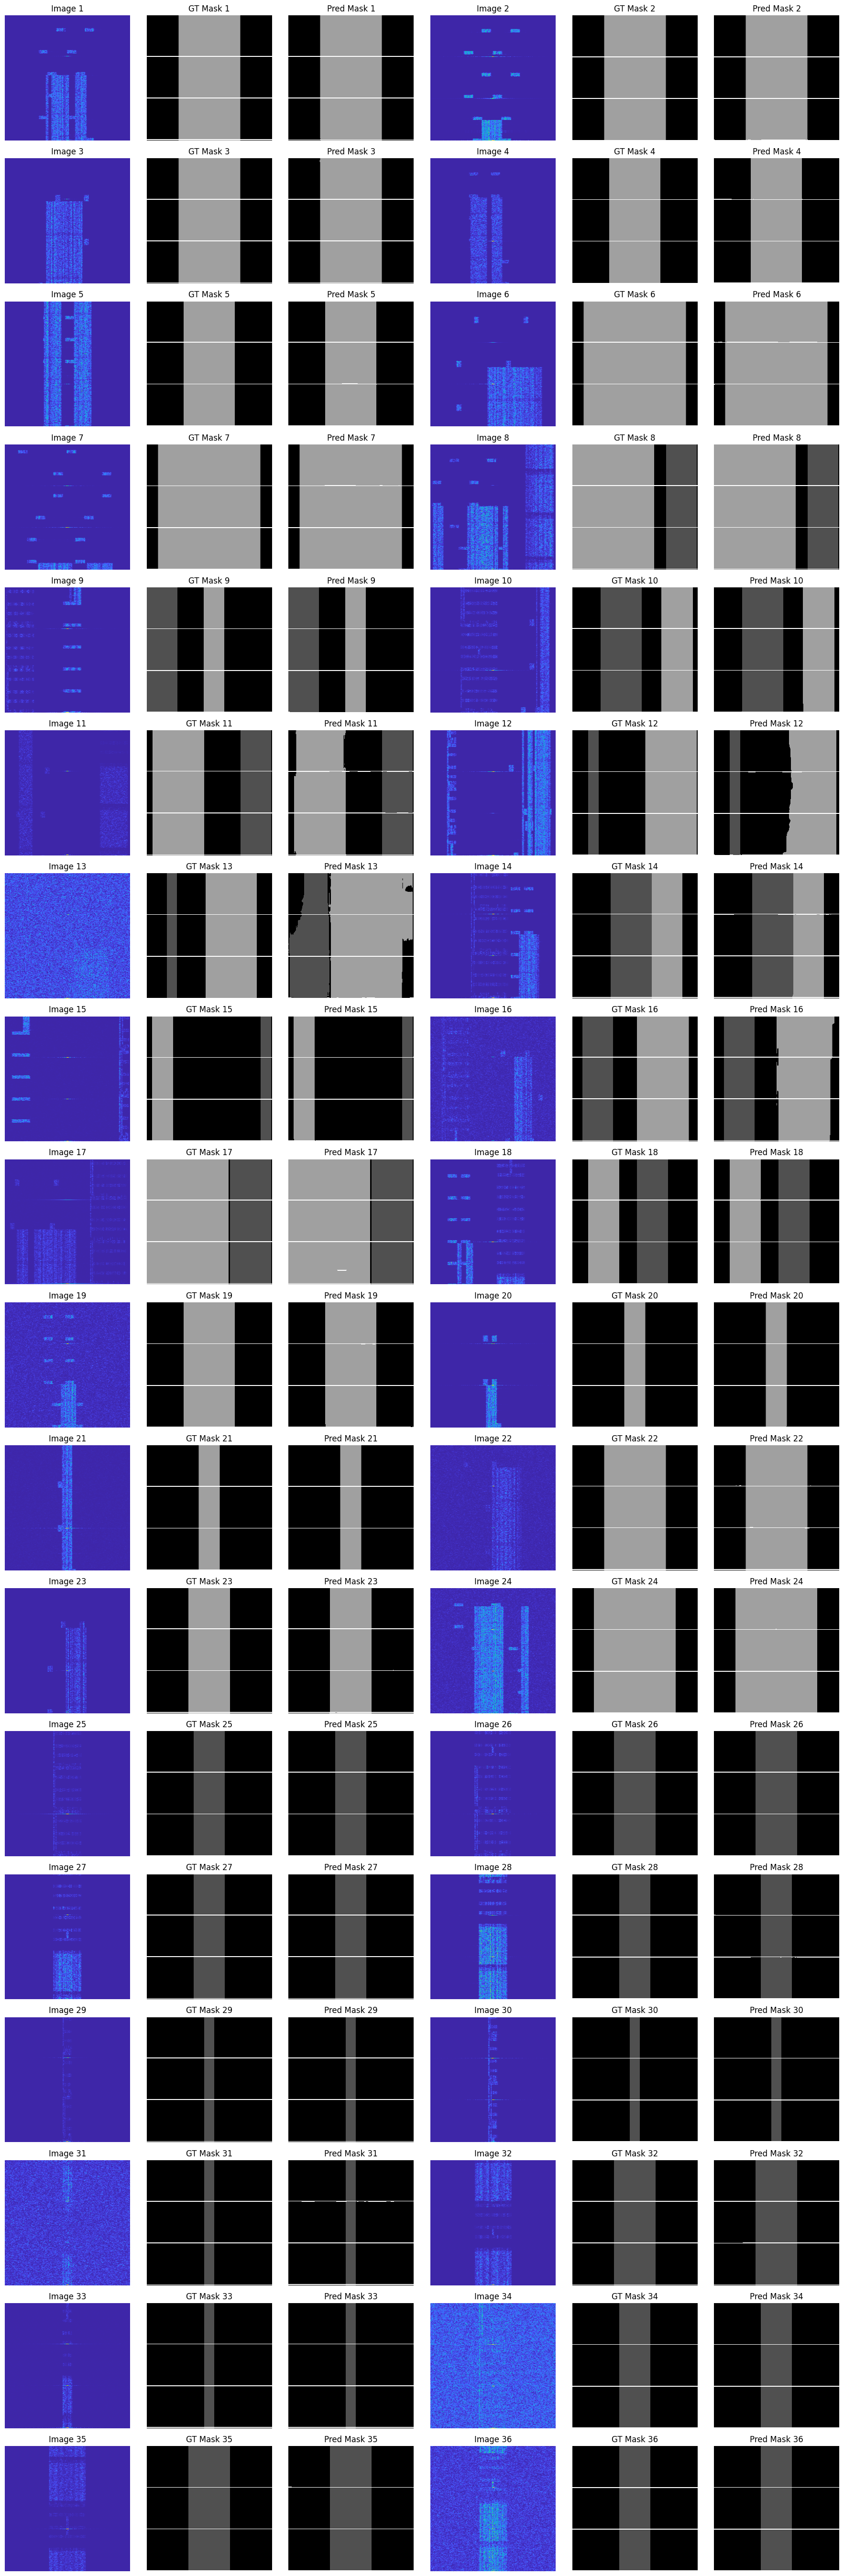

In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
from matplotlib.colors import ListedColormap # Đảm bảo đã import
import glob
import os

# --- Hàm để hiển thị ảnh, ground truth mask và predicted mask (ĐÃ CẬP NHẬT) ---
def visualize_segmentation(images_tensor, true_masks_tensor, pred_masks_tensor, colormap_definition, num_samples=36, num_cols=6):
    """
    Hiển thị các mẫu ảnh, ground truth mask và predicted mask.
    Args:
        images_tensor (Tensor): Batch ảnh (N, C, H, W) đã được chuẩn hóa từ DataLoader.
                                Giá trị pixel được giả định trong khoảng [0, 1].
        true_masks_tensor (Tensor): Batch ground truth masks (N, H, W) chứa chỉ số lớp.
        pred_masks_tensor (Tensor): Batch predicted masks (N, H, W) chứa chỉ số lớp.
        colormap_definition (list): List các màu [[R,G,B], ...] cho các lớp.
        num_samples (int): Số lượng mẫu cần hiển thị.
        num_cols (int): Số cột trong lưới hiển thị.
    """
    images_np_list = []
    # images_tensor là (N,C,H,W) tensor với giá trị pixel trong khoảng [0,1]
    for img_t in images_tensor:
        img_chw_01 = img_t.cpu().numpy() # (C,H,W), giá trị trong [0,1]
        img_hwc_uint8 = (img_chw_01.transpose(1, 2, 0) * 255).astype(np.uint8)
        images_np_list.append(img_hwc_uint8)

    true_masks_np = true_masks_tensor.cpu().numpy()
    pred_masks_np = pred_masks_tensor.cpu().numpy()

    # Điều chỉnh số lượng mẫu thực tế nếu không đủ
    actual_num_samples = min(num_samples, len(images_np_list))
    if actual_num_samples == 0:
        print("Không có mẫu nào để hiển thị.")
        return
        
    total_items = actual_num_samples * 3
    num_rows = (total_items + num_cols - 1) // num_cols # Làm tròn lên

    fig_height = num_rows * 3 # Điều chỉnh chiều cao dựa trên số hàng
    fig_width = num_cols * 3

    plt.figure(figsize=(fig_width, fig_height))

    custom_cmap = ListedColormap(np.array(colormap_definition) / 255.0)
    num_classes = len(colormap_definition)

    for i in range(actual_num_samples):
        plot_idx_base = i * 3

        # Ảnh gốc
        plt.subplot(num_rows, num_cols, plot_idx_base + 1)
        plt.imshow(images_np_list[i])
        plt.title(f"Image {i+1}")
        plt.axis('off')

        # Ground Truth Mask
        plt.subplot(num_rows, num_cols, plot_idx_base + 2)
        plt.imshow(true_masks_np[i], cmap=custom_cmap, vmin=0, vmax=num_classes-1)
        plt.title(f"GT Mask {i+1}")
        plt.axis('off')

        # Predicted Mask
        plt.subplot(num_rows, num_cols, plot_idx_base + 3)
        plt.imshow(pred_masks_np[i], cmap=custom_cmap, vmin=0, vmax=num_classes-1)
        plt.title(f"Pred Mask {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


try:
    model_files = glob.glob("epoch_*_GlobalAccuracy_*_MeanIoU_*.pth")
    if not model_files:
        raise FileNotFoundError("Không tìm thấy file.")


    model_files.sort(key=lambda f:
                     (lambda parts:
                          # Định dạng chính: epoch_XX_GlobalAccuracy_YY.YYYY_MeanIoU_ZZ.ZZZZ
                          (float(parts[5]) if len(parts) > 5 and parts[4] == 'MeanIoU' else -1.0, # Ưu tiên MeanIoU
                           int(parts[1]) if len(parts) > 1 else -1) # Sau đó là epoch
                           # if len(parts) > 0 and parts[0] == 'epoch'
                           # Định dạng fallback: best_model_epoch_XX_acc_YY.YYYY (Sắp xếp theo acc nếu không có MeanIoU)
                           # else (float(parts[5]) if len(parts) > 5 and parts[4] == 'acc' else -1.0,
                           #       int(parts[3]) if len(parts) > 3 else -1)
                           #       if len(parts) > 1 and parts[0] == 'best' and parts[1] == 'model'
                           #       # Mặc định cho các tên file không khớp
                           #       else (-1.0, -1)
                     )(os.path.basename(f).replace('.pth', '').split('_')), # Phân tích tên file
                     reverse=True) # Sắp xếp giảm dần để lấy giá trị cao nhất trước

    best_path = model_files[0]
    print(f"Đang tải trọng số từ: {best_path}")

    checkpoint = torch.load(best_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    model.to(device)
    model.eval() # Đặt model ở chế độ đánh giá
    print("Đã tải trọng số thành công!")

except FileNotFoundError as e:
    print(e)
except Exception as e:
    print(f"Lỗi khi tải model: {e}")



if 'model' in locals() and hasattr(model, 'load_state_dict') and 'testloader' in globals() and 'COLORMAP' in globals():
    try:
        all_images_tensors_list = []
        all_true_masks_tensors_list = []

        for batch_idx, (x_test_batch, y_test_batch) in enumerate(testloader):
            all_images_tensors_list.append(x_test_batch)
            all_true_masks_tensors_list.append(y_test_batch)


        if not all_images_tensors_list:
            print("Không có dữ liệu nào được lấy từ testloader.")
        else:
            # Ghép toàn bộ dữ liệu đã lấy từ testloader
            all_images_combined = torch.cat(all_images_tensors_list, dim=0)
            all_true_masks_combined = torch.cat(all_true_masks_tensors_list, dim=0)

            num_total_available = all_images_combined.size(0)

            num_to_visualize = min(36, num_total_available)

            if num_to_visualize > 0:
                if num_to_visualize == 1:
                    sampled_indices = [0]
                else:
                    step = num_total_available / num_to_visualize
                    sampled_indices = [int(i * step) for i in range(num_to_visualize)]
                    sampled_indices = [min(idx, num_total_available - 1) for idx in sampled_indices]


                print(f"Đã lấy TOÀN BỘ dữ liệu từ testloader ({num_total_available} mẫu).")
                print(f"Tuy nhiên, chỉ hiển thị {num_to_visualize} mẫu cách đều với các chỉ mục: {sampled_indices}")

                # Lấy các mẫu đã chọn để hiển thị
                sampled_images_tensor = all_images_combined[sampled_indices]
                sampled_masks_tensor = all_true_masks_combined[sampled_indices]

                sampled_images_tensor_dev = sampled_images_tensor.to(device).float()

                pred_masks_list = []
                with torch.no_grad():
                    outputs = model(sampled_images_tensor_dev)
                    predictions = torch.softmax(outputs, dim=1).argmax(dim=1)
                    pred_masks_list.extend(predictions.cpu())

                final_pred_masks_tensor = torch.stack(pred_masks_list)

                visualize_segmentation(
                    sampled_images_tensor,        # Tensor ảnh gốc (đã chuẩn hóa)
                    sampled_masks_tensor,         # Tensor mặt nạ ground truth
                    final_pred_masks_tensor,      # Tensor mặt nạ dự đoán
                    COLORMAP,                     # Định nghĩa colormap
                    num_samples=num_to_visualize
                )
            else:
                print(f"Đã lấy TOÀN BỘ dữ liệu từ testloader ({num_total_available} mẫu), nhưng không có mẫu nào được chọn để hiển thị (num_to_visualize là 0).")

    except NameError as e:
        print(f"Lỗi NameError: {e}. Đảm bảo các biến cần thiết (như 'device', 'visualize_segmentation') đã được định nghĩa.")
    except Exception as e:
        print(f"Có lỗi xảy ra trong quá trình dự đoán hoặc hiển thị: {e}")
else:
    print("Mô hình chưa được tải hoặc 'testloader'/'COLORMAP' chưa được định nghĩa. Bỏ qua phần hiển thị.")
